<a href="https://www.kaggle.com/code/hariharan849/100sports-tensorflow?scriptVersionId=208596604" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sports-classification/EfficientNetB0-100-(224 X 224)- 98.40.h5
/kaggle/input/sports-classification/sports.csv
/kaggle/input/sports-classification/valid/bobsled/5.jpg
/kaggle/input/sports-classification/valid/bobsled/1.jpg
/kaggle/input/sports-classification/valid/bobsled/4.jpg
/kaggle/input/sports-classification/valid/bobsled/3.jpg
/kaggle/input/sports-classification/valid/bobsled/2.jpg
/kaggle/input/sports-classification/valid/hurdles/5.jpg
/kaggle/input/sports-classification/valid/hurdles/1.jpg
/kaggle/input/sports-classification/valid/hurdles/4.jpg
/kaggle/input/sports-classification/valid/hurdles/3.jpg
/kaggle/input/sports-classification/valid/hurdles/2.jpg
/kaggle/input/sports-classification/valid/snow boarding/5.jpg
/kaggle/input/sports-classification/valid/snow boarding/1.jpg
/kaggle/input/sports-classification/valid/snow boarding/4.jpg
/kaggle/input/sports-classification/valid/snow boarding/3.jpg
/kaggle/input/sports-classification/valid/snow boarding/2.jpg
/kaggl

In [2]:
# imports

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.patheffects import withStroke
try:
    import mplcyberpunk
except:
    print("[INFO] Couldn't find mplcyberpunk... installing it.")
    !pip install -q mplcyberpunk
    import mplcyberpunk
plt.style.use("cyberpunk")

from tqdm.keras import TqdmCallback
#keras
import tensorflow as tf
from keras import layers, Model
from keras.models import Sequential
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

[INFO] Couldn't find mplcyberpunk... installing it.


In [3]:
gpiosenka_sports_classification_path = "/kaggle/input/sports-classification"
dataset = pd.read_csv(os.path.join(gpiosenka_sports_classification_path, 'sports.csv'))

train_image_dir = os.path.join(gpiosenka_sports_classification_path, 'train')
valid_image_dir = os.path.join(gpiosenka_sports_classification_path, 'valid')
test_image_dir = os.path.join(gpiosenka_sports_classification_path, 'test')

In [4]:
dataset.head()

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


In [5]:
dataset["filepaths"] = dataset["filepaths"].apply(lambda x: os.path.join(gpiosenka_sports_classification_path, x))

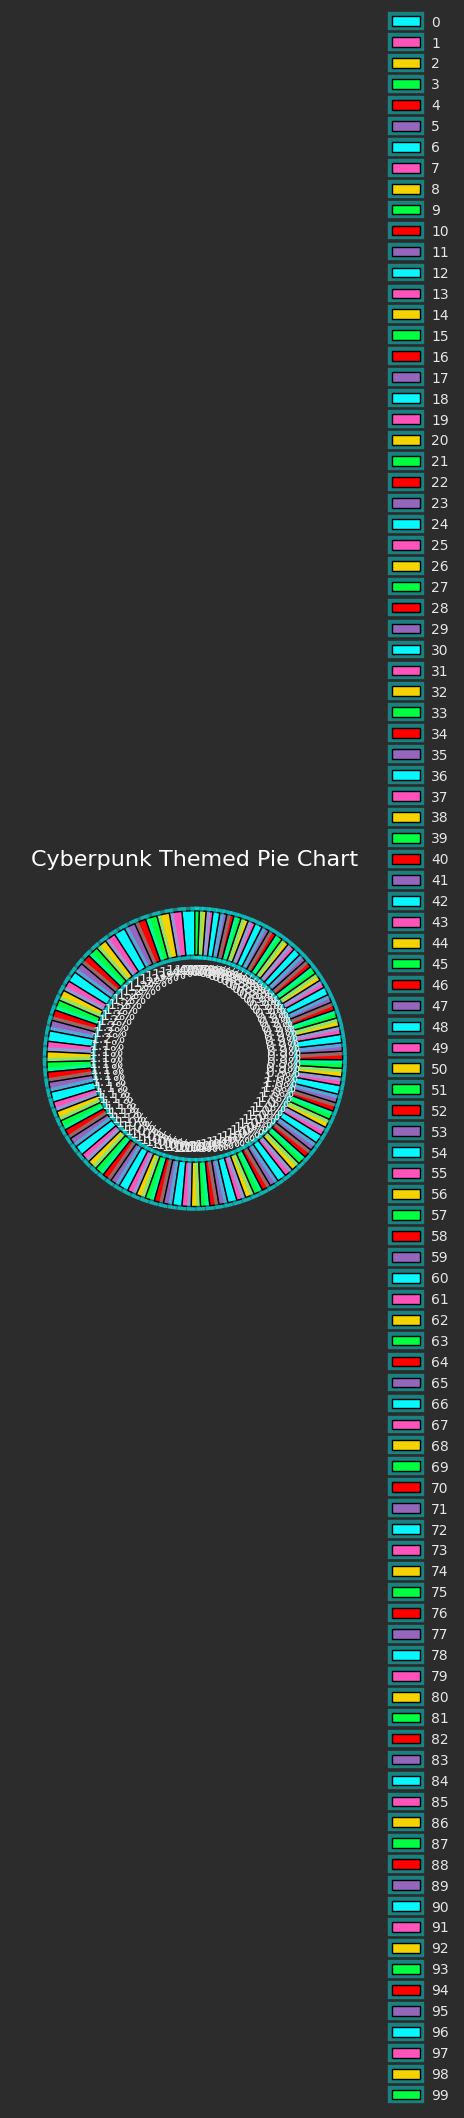

In [6]:
# Assuming your data is in a pandas DataFrame called 'train_df'
sports_counts = dataset['labels'].value_counts()

fig, ax = plt.subplots()
wedges, texts, _ = ax.pie(
    sports_counts.values.astype("float"), startangle=90,
    autopct='%1.1f%%', wedgeprops=dict(width=0.3, edgecolor='black')
)

# Add glow effect to each wedge
for wedge in wedges:
    wedge.set_path_effects([withStroke(linewidth=6, foreground='cyan', alpha=0.4)])

# Optional: Add a reflection effect
mplcyberpunk.add_glow_effects(ax)

# Customize chart labels
plt.legend(dataset.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10, facecolor='#222222')

# Dark background for the cyberpunk look
fig.patch.set_facecolor('#2c2c2c')
ax.set_facecolor('#2c2c2c')

# Title
plt.title("Cyberpunk Themed Pie Chart", color="white", fontsize=16)

plt.show()

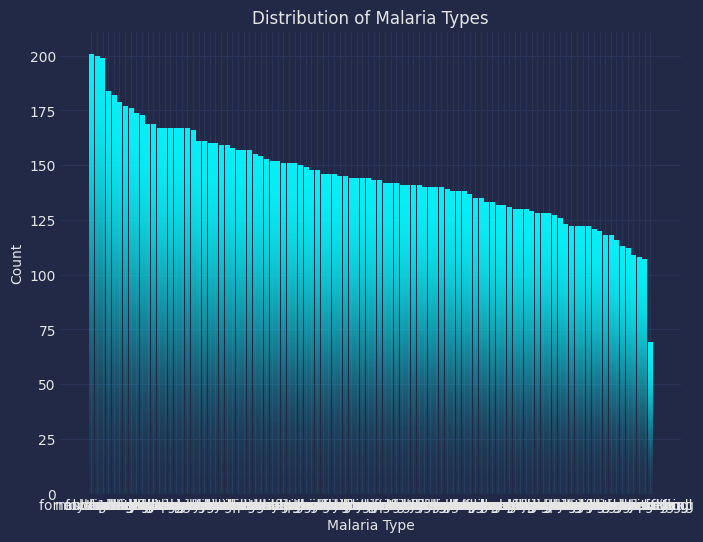

In [7]:
plt.figure(figsize=(8, 6))
bars = plt.bar(sports_counts.index, sports_counts.values)
mplcyberpunk.add_bar_gradient(bars=bars)
plt.xlabel('Malaria Type')
plt.ylabel('Count')
_ = plt.title('Distribution of Malaria Types')

In [8]:
#dataset preperations
validation_split= 0.2

train_df = dataset[dataset["data set"] == "train"]
valid_df = dataset[dataset["data set"] == "valid"]
test_df = dataset[dataset["data set"] == "test"]

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    horizontal_flip=True,
    validation_split = validation_split,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest"
)
train_df["filepaths"] = train_df["filepaths"].apply(lambda x: os.path.join(gpiosenka_sports_classification_path, x))

valid_datagen = ImageDataGenerator(rescale=1/255.0)
valid_df["filepaths"] = valid_df["filepaths"].apply(lambda x: os.path.join(gpiosenka_sports_classification_path, x))

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepaths",
    y_col="labels",
    seed=45,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='sparse'
)
val_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col="filepaths",
    y_col="labels",
    seed=45,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='sparse'
)
test_df["filepaths"] = test_df["filepaths"].apply(lambda x: os.path.join(gpiosenka_sports_classification_path, x))
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
)


/tmp/ipykernel_23/1822093160.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["filepaths"] = train_df["filepaths"].apply(lambda x: os.path.join(gpiosenka_sports_classification_path, x))
/tmp/ipykernel_23/1822093160.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["filepaths"] = valid_df["filepaths"].apply(lambda x: os.path.join(gpiosenka_sports_classification_path, x))


Found 13492 validated image filenames belonging to 100 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 500 validated image filenames belonging to 100 classes.


/tmp/ipykernel_23/1822093160.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["filepaths"] = test_df["filepaths"].apply(lambda x: os.path.join(gpiosenka_sports_classification_path, x))


Found 500 validated image filenames belonging to 100 classes.


In [9]:

AUTOTUNE = tf.data.AUTOTUNE
img_height = img_width = 224

def generator_to_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )

train_dataset_tune = generator_to_dataset(train_gen)
val_dataset_tune = generator_to_dataset(val_gen)

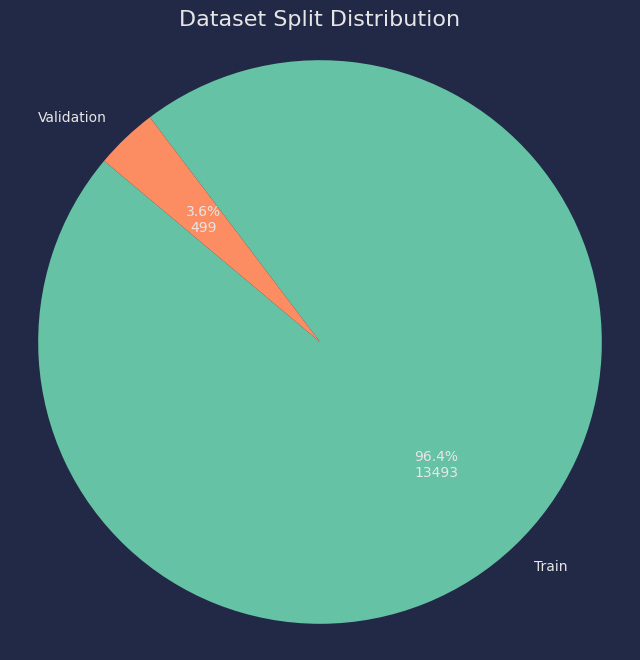

In [10]:
val_size = len(test_df)
train_size = len(train_df)

sizes = [train_size, val_size]
labels = ['Train', 'Validation']
colors = ['#66c2a5', '#fc8d62']

def autopct_format(value):
    """Formats the autopct value to display the percentage and count."""
    total = sum(sizes)
    percentage = f'{value:.1f}%'
    count = int(value * total / 100)
    return f'{percentage}\n{count}'

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct=autopct_format, startangle=140)
plt.title('Dataset Split Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [11]:
class_names = train_df["labels"].unique()

base_model = DenseNet121(weights='imagenet', include_top=False)
base_model.trainable = False
# Enable the last 5 layers of VGG16 to be trainable
for layer in base_model.layers[-5:]:  # Last 5 layers
    layer.trainable = True

data_augmentation = Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.2)
    ]
)

input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape, name="input_layer")

# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)  # Add a fully connected layer
x = layers.Dropout(0.5)(x)                   # Dropout layer for regularization
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

model_densenet = Model(inputs, outputs)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, min_delta=0.001)

# construct the callback to save only the *best* model to disk based on the validation loss
fname = os.path.sep.join(["/content/sample_data", "weights-{epoch:03d}-{val_loss:.4f}.keras"])
checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=5)

callbacks = [reduce_lr, checkpoint, es, tensorboard_callback, TqdmCallback(verbose=1)]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [13]:
model_densenet.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])
model_densenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,613,604 (29.04 MB)

 Trainable params: 615,012 (2.35 MB)

 Non-trainable params: 6,998,592 (26.70 MB)

In [14]:
history = model_densenet.fit(train_dataset_tune,
    epochs=20,
    steps_per_epoch=train_gen.samples//32,
    validation_data=val_dataset_tune,
    validation_steps=val_gen.samples//32,
    verbose=1
  )

Epoch 1/20


I0000 00:00:1732103128.923651      77 service.cc:145] XLA service 0x7b8b64002450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732103128.923745      77 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732103128.923752      77 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/421 ━━━━━━━━━━━━━━━━━━━━ 3:15:21 28s/step - accuracy: 0.0000e+00 - loss: 5.6930

I0000 00:00:1732103144.398134      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


421/421 ━━━━━━━━━━━━━━━━━━━━ 231s 484ms/step - accuracy: 0.0340 - loss: 4.6519 - val_accuracy: 0.3271 - val_loss: 3.2718
Epoch 2/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 160s 350ms/step - accuracy: 0.2043 - loss: 3.4758 - val_accuracy: 0.6068 - val_loss: 1.9749
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 144s 343ms/step - accuracy: 0.3435 - loss: 2.6788 - val_accuracy: 0.7329 - val_loss: 1.3307
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 144s 343ms/step - accuracy: 0.4363 - loss: 2.1959 - val_accuracy: 0.7628 - val_loss: 1.0961
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 144s 343ms/step - accuracy: 0.5057 - loss: 1.9192 - val_accuracy: 0.8098 - val_loss: 0.8568
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 145s 346ms/step - accuracy: 0.5513 - loss: 1.7140 - val_accuracy: 0.8162 - val_loss: 0.7352
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 145s 344ms/step - accuracy: 0.5807 - loss: 1.5623 - val_accuracy: 0.8355 - val_loss: 0.6668
Epoch 8/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 143s 341ms/step - accuracy: 0.6176 - loss: 1.42

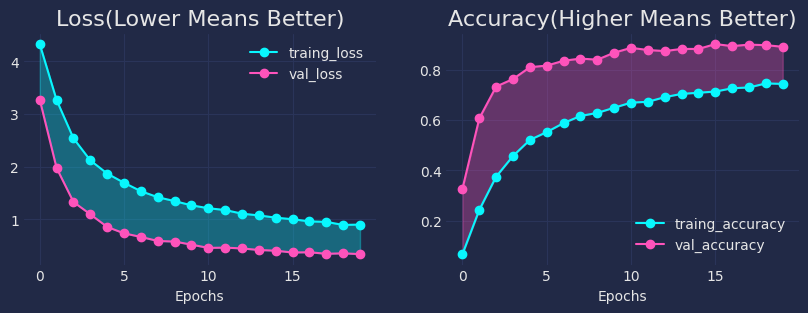

In [15]:
def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])

    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])

    epochs= range(len(history.history['loss']))

    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))

    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')

    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)

    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)

    ax1.legend()

    #plot Accuracy
    ax2.plot(epochs, accuracy, label='traing_accuracy', marker='o')

    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)

    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)

    ax2.legend()

plot_training_curves(history)

In [16]:
import numpy as np
# Interpret predictions
predictions = model_densenet.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [class_names[i] for i in predicted_classes]

# Add predicted labels to DataFrame
test_df['predicted_class'] = predicted_labels

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 642ms/step


/tmp/ipykernel_23/2298780604.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_class'] = predicted_labels


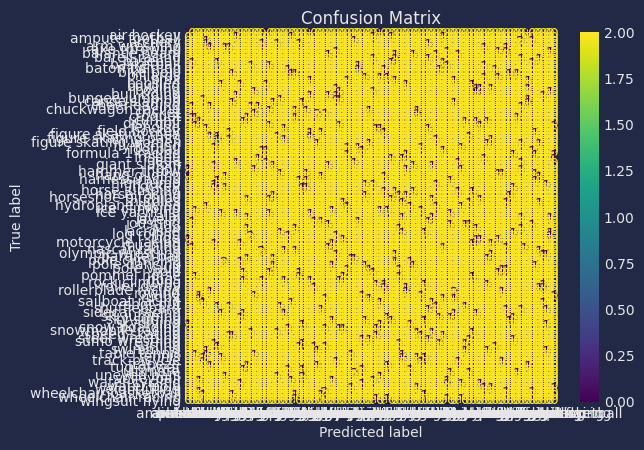

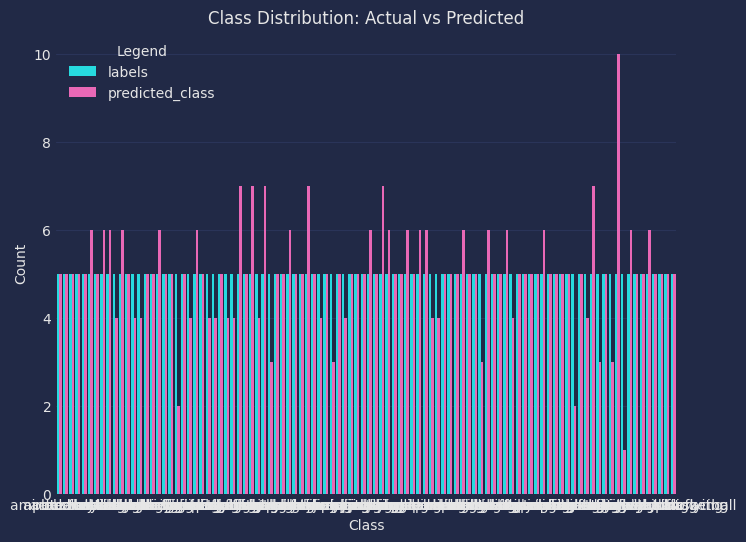

In [17]:
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_df['labels'], test_df['predicted_class'], labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Bar plot for class distribution
# Melt data for bar plot
melted_data = test_df.melt(id_vars='filepaths', value_vars=['labels', 'predicted_class'],
                             var_name='Type', value_name='Class')

# Plot
plt.figure(figsize=(8, 6))
sns.countplot(data=melted_data, x='Class', hue='Type')
plt.title('Class Distribution: Actual vs Predicted')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Legend')
plt.show()